# Stimulus Generation: Face Scrambling

## Setup

In [1]:
# <api>
%load_ext jupyter_cms
%matplotlib inline

In [2]:
# <api>
import os
import sys

import numpy as np
from matplotlib import pyplot as plt
import random

import cv2
from skimage import io
from sklearn.feature_extraction import image
from skimage.util.shape import view_as_blocks
import itertools

import mywb.face_detection as fd
#reload(fd)

## Explanation
The code aims to be as simple as possible. The heavy lifting is done by `cv2.pointPolygonTest`. First, 'tickmarks' of blocks are generated according to the desired block size in pixels (18x18 in our case):

Let's try it out and plot the grid

{u'adjusts': [21, 0, 29, 0], u'width_mult': 0.8, 'plot_el': True, u'height_mult': 1.11, u'x_offset': -6L, u'y_offset': -9L}


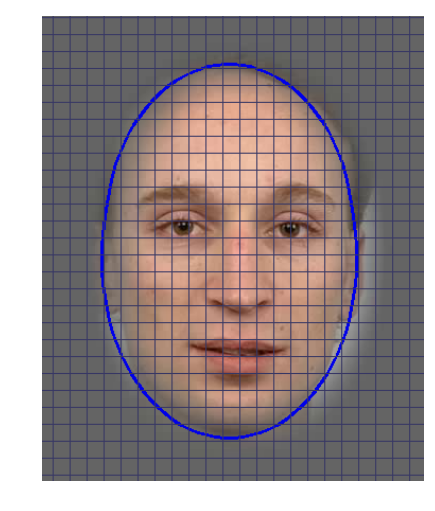

In [7]:
img = './img/fre99m03_frame_1.jpg'
args = fd.get_stasm_args(img, plot_el=True)
print args
im, el = fd.get_stasm_el(img = img, **args)

im_demo = im.copy()
block_size=(16, 16)
ticks_y, ticks_x = create_block_coords(im.shape, block_size=block_size)
ticks = list(itertools.product(ticks_x, ticks_y))
for point in ticks:
    pt_op = (point[0]+block_size[0], point[1]+block_size[1])
    cv2.rectangle(im_demo, point,pt_op, color=(55,55,100), thickness=1)
fd.simple_implot(im_demo)

Next, those blocks that are inside the region of interest (the face area) need to be identified. For that, we iterate over the 'tick-marks' created above. As those iterations operate top->down and left->right, each tick-mark can be interpereted as the upper left corner of the corresponding block. We simply have to check if the current tick-mark (upper left corner) and the other four corners of the block are inside the given shape. The is-the-point-in-a-shape problem can get rather complex, but luckily OpenCV's `pointPolygonTest` takes care of that.

In [3]:
# <api>

def create_block_coords(im_shape, block_size, jitter=0):
    """ generates a grid of block coordinates with the same dimension as the diven image
    """
    ticks_x = np.arange(0, im_shape[1], step=block_size[1])[0:-1] # don't go beyond image boundaries
    ticks_y = np.arange(0, im_shape[0], step=block_size[0])[0:-1]
    ticks = (ticks_y, ticks_x)
    return ticks

In [4]:
# <api>
def find_block_coords_inside(shape, ticks):
    """ steps through the given grid and checks each block whether it's inside the given shape
    relies heavily on cv2.pointPolygonTest
    """
    ticks_y = ticks[0]
    ticks_x = ticks[1]
    bl_x = ticks_x[1] - ticks_x[0]
    bl_y = ticks_y[1] - ticks_y[0]
    
    ticks_inside = []
    ids_inside = []
    idx_x = 0
    for tick_x in ticks_x:
        idx_y = 0
        for tick_y in ticks_y:
            point_tl = (tick_y, tick_x) # top left corner of a block
            tl_inside = cv2.pointPolygonTest(shape,point_tl,False) >= 0   
            if tl_inside: # the top left corner of the block is inside - what about the rest?
                point_tr = (tick_y, tick_x+bl_x)
                point_br = (tick_y+bl_y, tick_x+bl_x)
                point_bl = (tick_y+bl_y, tick_x)
                tr_inside = cv2.pointPolygonTest(shape,point_tr,False) >= 0
                br_inside = cv2.pointPolygonTest(shape,point_br,False) >= 0
                bl_inside = cv2.pointPolygonTest(shape,point_bl,False) >= 0
                if tr_inside and br_inside and bl_inside:
                    ticks_inside.append(point_tl)
                    ids_inside.append((idx_x, idx_y)) # (idx_y, idx_x)? (idn_y, idn_x below)
            idx_y += 1
        idx_x += 1
    return ticks_inside, ids_inside

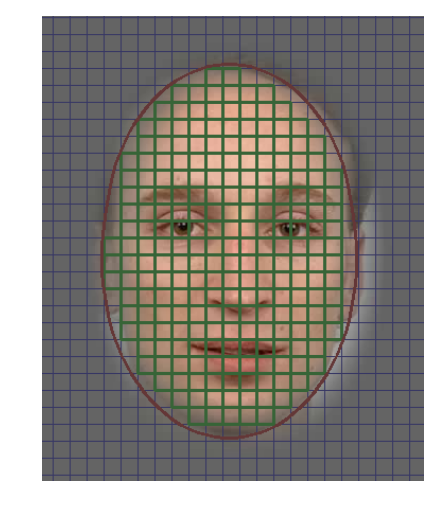

In [8]:
img = './img/fre99m03_frame_1.jpg'
args = fd.get_stasm_args(img, plot_el=True)
#im, el = fd.get_stasm_el(img = img, **args)

ticks_inside, ids_inside = find_block_coords_inside(el, (ticks_y, ticks_x))
for point in ticks_inside:
    pt_op = (point[0]+block_size[0], point[1]+block_size[1])
    cv2.rectangle(im_demo, point,pt_op, color=(55,100,55), thickness=2)
cv2.polylines(im_demo, np.int32([el]), True, (100,55,55), thickness=2)
fd.simple_implot(im_demo)

Now we are ready to split the 'actual' image into blocks, map those blocks to the tick-marks we have been working with thus far, and scramble those blocks accordingly:

In [5]:
# <api>
def _split_image_blocks(im, block_size):
    """ takes an image and splits it into blocks of the given size. Returns a 2D array of those blocks
    """
    # have to crop the image so we can split it into blocks:
    height = int(im.shape[0]/block_size[0]) * block_size[0]
    width = int(im.shape[1]/block_size[1]) * block_size[1]
    im = im[0:height, 0:width]
        
    blocks = []
    blocks = map(lambda x : np.split(x, im.shape[1]/block_size[1], 1), # Split the columns
                            np.split(im, im.shape[0]/block_size[0], 0)) # Split the rows
    #import pdb
    #pdb.set_trace()
    blocks = np.array(blocks)
    return blocks

def apply_block_list(blocks, ids_inside, shuffle=False):
    """
    takes in a list of blocks and the ids of those that should be shuffled
    returns all blocks
    """
    blocks_copy = blocks.copy()
    if shuffle:
        randomized_block_list = np.random.permutation(ids_inside)
    else:
        randomized_block_list = np.array(ids_inside)
    idx_y = 0
    for row in blocks:
        idx_x = 0
        for block in row:
            this_block_id = (idx_y, idx_x)
            if this_block_id in ids_inside:
                idn_y, idn_x = randomized_block_list[0] # get random block_id that will be moved to this_block    
                randomized_block_list = np.delete(randomized_block_list,[0], axis=0)
                blocks[idx_y, idx_x] = blocks_copy[idn_y, idn_x]
            idx_x += 1
        idx_y += 1
    return blocks

def _im_from_blocks(blocks):
    """ stick list of blocks together
    """
    im = []
    im = np.hstack(blocks[0])
    import pdb
    #pdb.set_trace()
    i = 0
    for row in blocks[1:]:
        row = np.hstack(row)
        if i == 7:
            #pdb.set_trace()
            pass
        try:
            im = np.vstack([im,row])
        except:
            pass
        i +=1
    return im
    

Finally, we can put it all together:

In [6]:
# <api>
def scramble_face(im, shape, block_size=(16,16), draw_el=False, draw_grid=False, apply_list=None):
    """ main stimulus generation function
    """
    bl_x = block_size[1] # in python image processing world, it's (height/y-coord,width/x-coordinate)
    bl_y = block_size[0]
    ticks = create_block_coords(im.shape, block_size)
    ticks_y, ticks_x = ticks[0], ticks[1]
    
    if not apply_list:
        ticks_inside, ids_inside = find_block_coords_inside(shape, ticks)
        random.shuffle(ids_inside)
    else:
        ids_inside = apply_list
        ticks_inside = [(ticks[0][x[0]], ticks[1][x[1]]) for x in ids_inside]
        import pdb
        #pdb.set_trace()

    # divide actual image into blocks
    blocks = _split_image_blocks(im, block_size)
   
    #scramble
    blocks = apply_block_list(blocks, ids_inside)

    # stitch blocks together again:
    im_sc = _im_from_blocks(blocks)
   
    
    if draw_el:
        cv2.polylines(im_sc, np.int32([shape]), True, (100,55,55), thickness=1)
    
    if draw_grid:
        ticks = list(itertools.product(ticks_x, ticks_y))
        i = 0
        for point in ticks:
            pt_op = (point[0]+bl_y, point[1]+bl_x)
            if point in ticks_inside:
                color=(55,100,55)
                cv2.rectangle(im_sc, point,pt_op, color, thickness=1)
            else:
                color=(55,55,100)
                if i%2==0 or bl_x>=18:
                    cv2.rectangle(im_sc, point,pt_op, color, thickness=1)
            i += 1
        
    return im_sc, ids_inside

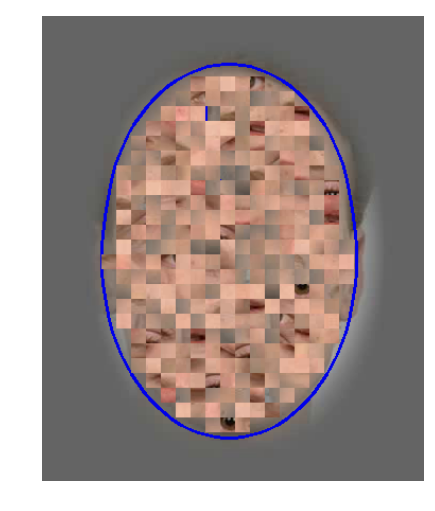

In [9]:
im_sc, ids_inside = scramble_face(im, el, draw_el=False, draw_grid=False, block_size=(14,14), apply_list=None)
fd.simple_implot(im_sc)

apply to whole list of frames

In [13]:
# <api>

def scramble_directory(input_dir, output_dir, block_size=(16,16)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    frames = os.listdir(input_dir)
    i = 0
    for frame in frames:
        source = os.path.join(input_dir, frame)
        target = os.path.join(output_dir, frame)
        args = fd.get_stasm_args(idx=source)
        (im, el) = fd.get_stasm_el(img=source, **args)
        if i==0:
            im_sc, ids_inside = scramble_face(im, el, apply_list=None, block_size=block_size
        else:
            im_sc, ids_inside = scramble_face(im, el, apply_list=ids_inside, block_size=block_size)
        #print "saving", source, "to", target
        io.imsave(target, im_sc)
        i += 1

In [14]:
scramble_directory('./all_frames/frames_fre99m03/', './all_frames_scrambled/frames_fre99m03/')
scramble_directory('./all_frames/frames_ekl99m03/', './all_frames_scrambled/frames_ekl99m03/')
#{u'adjusts': [21, 0, 29, 0], u'width_mult': 0.8, 'plot_el': True, u'height_mult': 1.11, u'x_offset': -6L, u'y_offset': -9L}

With the above function, we can finally scramble all frames of the videos:

In [15]:
frame_dir = './all_frames/'
frame_scrambled_dir = './all_frames_scrambled'
stimuli = os.listdir(frame_dir)

for stim in stimuli:
    print "scrambling", stim
    source_dir = os.path.join(frame_dir, stim)
    target_dir = os.path.join(frame_scrambled_dir, stim)
    scramble_directory(source_dir, target_dir)

scrambling frames_ekl99m03
scrambling frames_ekl99m05
scrambling frames_ekl99m07
scrambling frames_ekl99m09
scrambling frames_ekl99m10
scrambling frames_ekl99m15
scrambling frames_ekl99m20
scrambling frames_ekl99m21
scrambling frames_ekl99m23
scrambling frames_ekl99m24
scrambling frames_ekl99m25
scrambling frames_ekl99m28
scrambling frames_ekl99m30
scrambling frames_ekl99m33
scrambling frames_ekl99m36
scrambling frames_ekl99m38
scrambling frames_ekl99m46
scrambling frames_ekl99m47
scrambling frames_ekl99m49
scrambling frames_ekl99m71
scrambling frames_ekl99w01
scrambling frames_ekl99w02
scrambling frames_ekl99w04
scrambling frames_ekl99w08
scrambling frames_ekl99w12
scrambling frames_ekl99w14
scrambling frames_ekl99w16
scrambling frames_ekl99w18
scrambling frames_ekl99w19
scrambling frames_ekl99w22
scrambling frames_ekl99w26
scrambling frames_ekl99w27
scrambling frames_ekl99w31
scrambling frames_ekl99w32
scrambling frames_ekl99w37
scrambling frames_ekl99w56
scrambling frames_ekl99w57
s